# Random Forest Image Classification



## Imports and function definitions

In [1]:
import numpy as np
import pandas as pd 
import cv2
from glob import glob
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
# Sumary stats function
def summary(array):
    min_val = np.min(array)
    max_val = np.max(array)
    sd = np.std(array)
    var = np.var(array)
    mean = np.mean(array)
    median = np.median(array)
    percentile25 = np.percentile(array, 25)
    percentile50 = np.percentile(array, 50)
    percentile75 = np.percentile(array, 75)
    
    summaryDict = {"max":max_val, 'min':min_val, "mean":mean, "median":median, "SD": sd, 
                   "var":var, "25th":percentile25, "50th": percentile50, "75th":percentile75 }
    return summaryDict

In [3]:
# plotting func to visulize correct and incorrect predictions of each class
def plot_hist_pred_vs_truth(y_pred, y_test):
    unique_labels = ['pure', 'broken', 'discolored', 'silkcut']
    n_classes = len(unique_labels)
    
    # get ture label counts 
    true_counts = pd.Series(y_test).value_counts()
    
    # count correct and incorrect occurences for each class
    correct_counts = [0,0,0,0]
    incorrect_counts = [0,0,0,0]
    for i in range(len(y_test)):
        if y_pred[i] == 'pure': 
            if y_test[i] == 'pure':
                correct_counts[0] += 1
            else:
                incorrect_counts[0] += 1
            continue
        if y_pred[i] == 'broken': 
            if y_test[i] == 'broken':
                correct_counts[1] += 1
            else:
                incorrect_counts[1] += 1
            continue
        if y_pred[i] == 'discolored': 
            if y_test[i] == 'discolored':
                correct_counts[2] += 1
            else:
                incorrect_counts[2] += 1
            continue
        if y_pred[i] == 'silkcut': 
            if y_test[i] == 'silkcut':
                correct_counts[3] += 1
            else:
                incorrect_counts[3] += 1
 
 
    plt.figure()
    plt.bar(unique_labels, true_counts)
    plt.xlabel('Class Label')
    plt.ylabel('Frequency')
    plt.title('Original Distribution of Samples')
    plt.xticks(unique_labels)

    # Plot the predicted label distribution with incorrect predictions stacked on top
    plt.figure()
    plt.bar(unique_labels, correct_counts, label='Correct')
    plt.bar(unique_labels, incorrect_counts, bottom=correct_counts, label='Incorrect')
    plt.xlabel('Class Label')
    plt.ylabel('Frequency')
    plt.title('Predicted Distribution of Samples')
    plt.xticks(unique_labels)
    plt.legend()

    plt.show()


In [4]:
# center cropping function
def center_crop(img, target_size):
    h, w = img.shape[:2]
    th, tw = target_size

    if h < th or w < tw:
        raise ValueError("Target size should be smaller than the input image size")

    x = (w - tw) // 2
    y = (h - th) // 2
    cropped_img = img[y:y+th, x:x+tw]

    return cropped_img

## Load in and Preprocess Data

In [5]:
# list files 
img_folder = './corn/train/*.png'
corn = glob(img_folder)

# Load in label table: 
train_csv = pd.read_csv("./corn/train.csv")
print(train_csv.head())

# grab class labels 
labels = train_csv['label']
labels.head()

   seed_id    view            image       label
0        0     top  train/00000.png      broken
1        1  bottom  train/00001.png        pure
2        3     top  train/00003.png      broken
3        4     top  train/00004.png        pure
4        5     top  train/00005.png  discolored


0        broken
1          pure
2        broken
3          pure
4    discolored
Name: label, dtype: object

In [6]:
# preprocess images: center crop and normalization 
target_size = (140,140)
croppedImages = []

for imgPth in corn:
    temp_img = cv2.imread(imgPth)
    if (temp_img.shape[0] >= target_size[0] & temp_img.shape[1] >= target_size[1]):
        croppedimg = center_crop(temp_img, target_size)
        croppedimg = (croppedimg / 255).astype(np.float32) # normalize
        croppedImages.append(croppedimg)
    else:
        resizedImg = cv2.resize(temp_img, target_size)
        resizedImg = (resizedImg / 255).astype(np.float32) # normalize
        croppedImages.append(resizedImg)

# Greyscale conversion and HOG feature extraction 
croppedImages_grey = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in croppedImages]

hog_features = [hog(img, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)) for img in croppedImages_grey]

In [7]:
# Inspect HOG features 
summary(hog_features)

# shape of HOG features 
print(len(hog_features[0]))
print(len(hog_features))

9216
14322


## Split Data, Train and Predict with Un-tuned Hyperparmeters


In [8]:
# split data, train model, make predictions
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=265)

In [9]:
# train classifer with naive settings, before grid search to establish baseline performance
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

      broken     0.4299    0.4571    0.4431       886
  discolored     0.3667    0.0215    0.0406       512
        pure     0.4921    0.7991    0.6091      1165
     silkcut     1.0000    0.0033    0.0066       302

    accuracy                         0.4705      2865
   macro avg     0.5722    0.3203    0.2748      2865
weighted avg     0.5040    0.4705    0.3927      2865



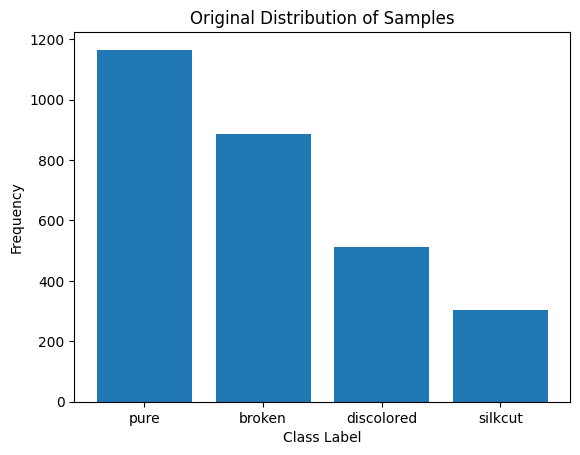

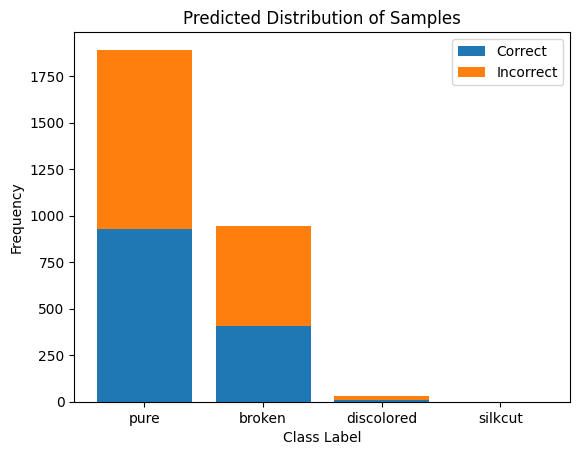

In [10]:
# View prediction results
plot_hist_pred_vs_truth(y_pred, y_test.tolist())

## Perform PCA on HOG - Then Cross Validation to find Best Hyperparameters
### (further preprocessing which will improve final results)

In [11]:
# 1000 components for hyperparameter tunning 
pca = PCA(n_components=1000) 
pca.fit(hog_features)
pca_hog_features = pca.transform(hog_features)

# Train Test Split for PCA data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_hog_features, labels, test_size=0.2, random_state=65)

In [13]:
# cross validation to find best number of folds and best number of PCA componenets
folds = 4
kf = KFold(n_splits=folds, shuffle=True, random_state=20)


min_samples_leaf = [1, 2, 4]
num_estimators = [50, 100, 250, 500, 1000, 1200]
num_pca_comp = [10, 20, 35, 50, 100, 500, 1000]

# Initialize an empty dict to store the average accuracy for each number of neighbors and components
best_params = {'num_estimators': None, 'n_components': None, 'max_features': None, 
               'min_samples_leaf': None, 'f1_score': 0}


for leaves in min_samples_leaf:
    for n_estimators in num_estimators:
        for n_components in num_pca_comp:

            # Create a RandomForestClassifier with the current parameters
            rf = RandomForestClassifier(n_estimators=n_estimators,
                                        min_samples_leaf=leaves,
                                        random_state=202)

            # Calculate the cross-validated f1_score for the current number of PCA components
            cv_f1 = cross_val_score(rf, X_train_pca[:, :n_components], y_train, cv=kf, scoring='f1_macro')

            # Compute the average f1_score across the folds
            avg_f1 = np.mean(cv_f1)

            # Update f1_score if better
            if avg_f1 > best_params['f1_score']:
                best_params['n_estimators'] = n_estimators
                best_params['n_components'] = n_components
                best_params['min_samples_leaf'] = leaves
                best_params['f1_score'] = avg_f1

print(f"Best parameters: {best_params}")

Best parameters: {'n_neighbors': None, 'n_components': 10, 'max_features': None, 'min_samples_leaf': 1, 'f1_score': 0.21916411137367614, 'n_estimators': 50}


In [19]:
# train model with best hyperparameters after cross validation grid search
rfc = RandomForestClassifier(n_estimators=1200, min_samples_leaf=1)
rfc.fit(X_train_pca[:, :50], y_train_pca)
y_pred_pca = rfc.predict(X_test_pca[:, :50])
print(classification_report(y_test_pca, y_pred_pca, digits = 4))

              precision    recall  f1-score   support

      broken     0.5036    0.4541    0.4776       916
  discolored     0.7500    0.0058    0.0115       520
        pure     0.4870    0.8600    0.6218      1150
     silkcut     0.5000    0.0072    0.0141       279

    accuracy                         0.4921      2865
   macro avg     0.5601    0.3318    0.2813      2865
weighted avg     0.5413    0.4921    0.4058      2865



In [20]:
# train model with best hyperparameters after cross validation grid search
rfc = RandomForestClassifier(n_estimators=800, min_samples_leaf=2)
rfc.fit(X_train_pca[:, :25], y_train_pca)
y_pred_pca = rfc.predict(X_test_pca[:, :25])
print(classification_report(y_test_pca, y_pred_pca, digits = 4))

              precision    recall  f1-score   support

      broken     0.5342    0.4945    0.5136       916
  discolored     0.5000    0.0115    0.0226       520
        pure     0.4942    0.8522    0.6256      1150
     silkcut     0.5909    0.0466    0.0864       279

    accuracy                         0.5068      2865
   macro avg     0.5298    0.3512    0.3120      2865
weighted avg     0.5175    0.5068    0.4278      2865



In [21]:
# train model with best hyperparameters after cross validation grid search
rfc = RandomForestClassifier(n_estimators=1000, min_samples_leaf=3, min_samples_split=3, verbose = 1)
rfc.fit(X_train_pca[:, :30], y_train_pca)
y_pred_pca = rfc.predict(X_test_pca[:, :30])
print(classification_report(y_test_pca, y_pred_pca, digits = 4))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   59.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

      broken     0.5377    0.4825    0.5086       916
  discolored     0.5556    0.0096    0.0189       520
        pure     0.4894    0.8617    0.6243      1150
     silkcut     0.4444    0.0143    0.0278       279

    accuracy                         0.5033      2865
   macro avg     0.5068    0.3421    0.2949      2865
weighted avg     0.5125    0.5033    0.4193      2865



[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.4s finished


In [22]:
# train model with best hyperparameters after cross validation grid search
rfc = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1)
rfc.fit(X_train_pca[:, :20], y_train_pca)
y_pred_pca = rfc.predict(X_test_pca[:, :20])
print(classification_report(y_test_pca, y_pred_pca, digits = 4))

              precision    recall  f1-score   support

      broken     0.5305    0.5120    0.5211       916
  discolored     0.4615    0.0115    0.0225       520
        pure     0.4990    0.8400    0.6261      1150
     silkcut     0.6250    0.0717    0.1286       279

    accuracy                         0.5099      2865
   macro avg     0.5290    0.3588    0.3246      2865
weighted avg     0.5145    0.5099    0.4345      2865



In [23]:
# train model with best hyperparameters after cross validation grid search
rfc = RandomForestClassifier(n_estimators=1000, min_samples_leaf=2)
rfc.fit(X_train_pca[:, :20], y_train_pca)
y_pred_pca = rfc.predict(X_test_pca[:, :20])
print(classification_report(y_test_pca, y_pred_pca, digits = 4))

              precision    recall  f1-score   support

      broken     0.5355    0.5186    0.5269       916
  discolored     0.8571    0.0115    0.0228       520
        pure     0.5008    0.8461    0.6292      1150
     silkcut     0.6429    0.0645    0.1173       279

    accuracy                         0.5138      2865
   macro avg     0.6341    0.3602    0.3240      2865
weighted avg     0.5904    0.5138    0.4366      2865



In [24]:
# train model with best hyperparameters after cross validation grid search
rfc = RandomForestClassifier(n_estimators=1000, min_samples_leaf=3)
rfc.fit(X_train_pca[:, :20], y_train_pca)
y_pred_pca = rfc.predict(X_test_pca[:, :20])
print(classification_report(y_test_pca, y_pred_pca, digits = 4))

              precision    recall  f1-score   support

      broken     0.5250    0.4934    0.5087       916
  discolored     0.7000    0.0135    0.0264       520
        pure     0.4937    0.8487    0.6242      1150
     silkcut     0.5294    0.0323    0.0608       279

    accuracy                         0.5040      2865
   macro avg     0.5620    0.3470    0.3050      2865
weighted avg     0.5446    0.5040    0.4239      2865



In [33]:
# train model with best hyperparameters after cross validation grid search
rfc = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1)
rfc.fit(X_train_pca[:, :15], y_train_pca)
y_pred_pca = rfc.predict(X_test_pca[:, :15])
print(classification_report(y_test_pca, y_pred_pca, digits = 4))

              precision    recall  f1-score   support

      broken     0.5259    0.4989    0.5120       916
  discolored     0.3600    0.0173    0.0330       520
        pure     0.4879    0.8096    0.6089      1150
     silkcut     0.4603    0.1039    0.1696       279

    accuracy                         0.4977      2865
   macro avg     0.4585    0.3574    0.3309      2865
weighted avg     0.4742    0.4977    0.4306      2865



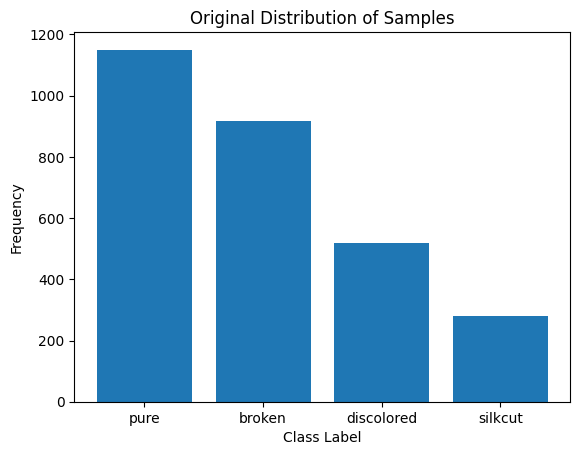

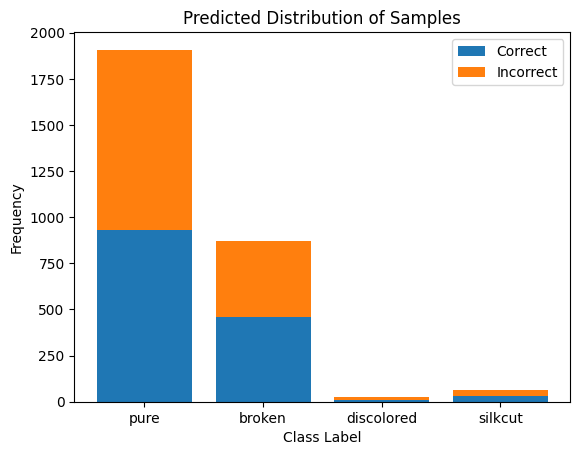

In [36]:
# View prediction results
plot_hist_pred_vs_truth(y_pred_pca, y_test_pca.tolist())

## SIFT --> RandomForest

In [37]:
# SIFT Feature Extraction and Train Test Split Func: 
def SIFT_extract_and_split(uint8_images, class_labels, no_split = False, train_test_random_state = 51, k_clusters = 50, print_num_featureless_images = True, SIFT_edgeThresh = 10, SIFT_sigma = 1.5):
  
  # Extract SIFT features
  sift = cv2.SIFT_create(edgeThreshold=SIFT_edgeThresh, sigma=SIFT_sigma)
  sift_features = [sift.detectAndCompute(img, None)[1] for img in uint8_images]
  
  # count none values, grab indices. (Since some images can fail to produce any points of interest for SIFT, they will be returned as None objects which need to be removed.) 
  none_count = 0
  none_idx = []
  for idx, features in enumerate(sift_features):
      if features is None:
          none_count+=1
          none_idx.append(idx)
          
  if print_num_featureless_images:
    print(none_count)
  
  # removing bad indices from sift_features and labels
  sift_features = [itm for idx, itm in enumerate(sift_features) if idx not in none_idx]
  sift_labels = [itm for idx, itm in enumerate(class_labels) if idx not in none_idx]
  
  # Stack all feature vectors
  all_features = np.vstack(sift_features)
  
  # Create visual vocabulary using k-means clustering
  # num of clusters == num visual words
  kmeans = KMeans(n_clusters=k_clusters, random_state=train_test_random_state)
  kmeans.fit(all_features)
  
  # Generate histograms of visual words for each image
  image_histograms = []
  for feature in sift_features:
      histogram = np.zeros(k_clusters)
      clusters = kmeans.predict(feature)
      for cluster in clusters:
          histogram[cluster] += 1
      image_histograms.append(histogram)
  
  if no_split:
    return image_histograms, sift_labels
  
    # split up new data features 
  X_train_sift, X_test_sift, y_train_sift, y_test_sift = train_test_split(image_histograms, sift_labels, test_size=0.2, random_state=51)
  
  return X_train_sift, X_test_sift, y_train_sift, y_test_sift


In [39]:
# convert images to uint8 format such that detectAndCompute can be used
croppedImages_grey_uint8 = [np.uint8(img * 255) for img in croppedImages_grey]

In [41]:
# SIFT extraction and split return
X_train_sift, X_test_sift, y_train_sift, y_test_sift = SIFT_extract_and_split(croppedImages_grey_uint8, labels, k_clusters=170, SIFT_edgeThresh=15, SIFT_sigma=.5)

rfc_sift = RandomForestClassifier(n_estimators=1000)
rfc_sift.fit(X_train_sift, y_train_sift)

161


c:\Users\Tanner_N\AppData\Local\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


RandomForestClassifier(n_estimators=1000)

In [42]:
# Evaluate the classifier on the test set
y_pred_sift = rfc_sift.predict(X_test_sift)
print(classification_report(y_test_sift, y_pred_sift, digits = 4))

              precision    recall  f1-score   support

      broken     0.4790    0.6078    0.5357       900
  discolored     0.4404    0.2038    0.2787       471
        pure     0.6112    0.7671    0.6803      1168
     silkcut     0.4286    0.0102    0.0199       294

    accuracy                         0.5443      2833
   macro avg     0.4898    0.3972    0.3787      2833
weighted avg     0.5218    0.5443    0.4991      2833



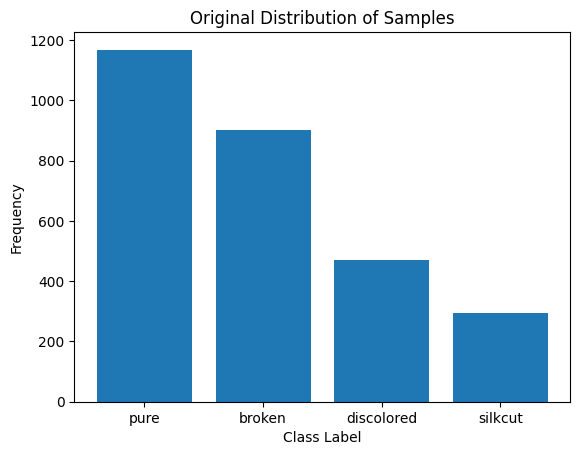

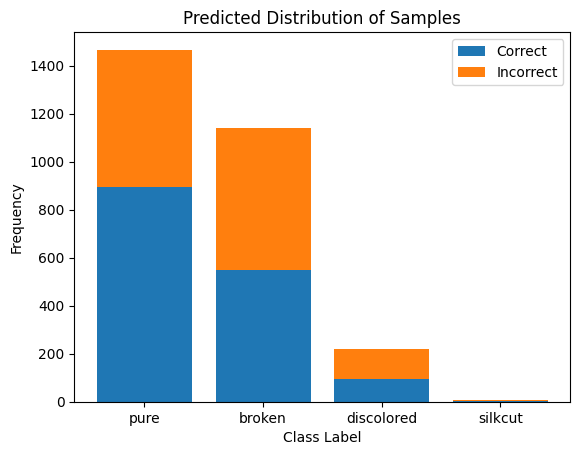

In [44]:
plot_hist_pred_vs_truth(y_pred_sift, y_test_sift) 